<h1 align="center"> Analysis of the "Golden Goal" IAP Strategies </h1>

<div>
    <h2>Table of Contents</h2>
    <ul>
        <li><a href="#introduction">Introduction</a></li>
        <li><a href="#data-set-preparation">Data Set Preparation</a>
            <ul>
                <li><a href="#data-cleaning">Data Cleaning</a></li>
                <li><a href="#merging-datasets">Merging Datasets</a></li>
                <li><a href="#feature-engineering">Feature Engineering</a></li>
                <li><a href="#dataframe-overview">Dataframe Overview</a></li>
            </ul>
        </li>
        <li><a href="#exploratory-data-analysis">Exploratory Data Analysis</a>
            <ul>
                <li><a href="#user-engagement">User Engagement</a></li>
                <li><a href="#purchasing-behavior">Purchasing Behavior</a></li>
            </ul>
        </li>
        <li><a href="#statistical-analysis">Statistical Analysis</a></li>
        <li><a href="#summary-of-results">Summary of the Results</a></li>
    </ul>
</div>

<style>
.anchor-tag {
    display: block;
    position: relative;
    top: -100px;
    visibility: hidden;
}
</style>

<a id="introduction" class="anchor-tag"></a>
<h1>Introduction</h1>

This report involves analyzing data from an A/B test in a mobile game, focusing on a product called Golden Goal. The test divided users into three groups: a control group with regular pricing and rewards, and two test groups, one with reduced pricing and regular rewards, and another with regular pricing but increased rewards. The task is to determine whether to maintain or alter the pricing and rewards of Golden Goal IAP. The goal is to provide insights, recommendations, and statistical evidence regarding the pricing and rewards of Golden Goal.

In [1]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import shapiro, levene, f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd


<style>
.anchor-tag {
    display: block;
    position: relative;
    top: -100px;
    visibility: hidden;
}
</style>

<a id="data-set-preparation" class="anchor-tag"></a>
<h1>Data Set Preparation</h1>

<style>
.anchor-tag {
    display: block;
    position: relative;
    top: -100px;
    visibility: hidden;
}
</style>

<a id="data-cleaning" class="anchor-tag"></a>
<h2>Data Cleaning</h2>

In [2]:
# Load the data from the daily activity CSV file
df_dau = pd.read_csv("data_daily_activity.csv")

# Display the first few rows of the dataframe 
df_dau.head()

,dateActivity,abTestGroup,platform,countryCode,userId
0,2019-12-02,test_group_2,Android,DE,i1impn4wxiuzilf
1,2019-12-10,test_group_1,Android,BR,o6t4n67wbgf1de4
2,2019-12-07,test_group_2,Android,IR,tjymyplb3uieesy
3,2019-12-07,control_group,Android,IT,dwar5ttp07awa0n
4,2019-12-06,test_group_2,Android,IT,vd5skmb26bwapmo


In [3]:
# Load the data from the in-app purchases CSV file
df_iap = pd.read_csv("data_in_app_purchases.csv")

# Display the first few rows of the dataframe
df_iap.head()

,productId,dateActivity,cost,userId
0,goldenspin,2019-12-10,1.99,otn5zom1ix8nj5k
1,endlessmatch,2019-12-02,1.99,m88jn740nhhic7s
2,specialpack26,2019-12-07,1.99,w90ri1qu1pk5d8f
3,specialpack26,2019-12-03,1.99,06ikm3ve8kec8v8
4,goldenspin,2019-12-03,1.99,omob080pkev7jqw


In [4]:
# Check for missing values
df_dau.isnull().sum()


dateActivity    0
abTestGroup     0
platform        0
countryCode     5
userId          0
dtype: int64

In [5]:
# Find the percentage of the null values
df_dau.isnull().sum() / len(df_dau) * 100

dateActivity    0.000000
abTestGroup     0.000000
platform        0.000000
countryCode     0.000801
userId          0.000000
dtype: float64

Since the percentage of the null values is very low, we will drop these values.

In [6]:
# Dropping rows with missing 'countryCode' in activity data
df_dau = df_dau.dropna(subset=['countryCode'])

In [7]:
# Show the data types
df_dau.dtypes

dateActivity    object
abTestGroup     object
platform        object
countryCode     object
userId          object
dtype: object

In [8]:
# Converting 'dateActivity' to datetime format
df_dau['dateActivity'] = pd.to_datetime(df_dau['dateActivity'])
df_dau.dtypes

dateActivity    datetime64[ns]
abTestGroup             object
platform                object
countryCode             object
userId                  object
dtype: object

In [9]:
df_iap.isnull().sum()

productId         0
dateActivity      0
cost            142
userId            0
dtype: int64

Since there is no null values in the 'productId' column, we can fill in the null values in the 'cost' variable by calculating the mean 'cost' for each product.

In [10]:
# Grouping the dataset by 'productId' and calculating the mean cost for each product
mean_cost_per_product = df_iap.groupby('productId')['cost'].mean()

# Filling the null values
df_iap['cost'] = df_iap.apply(lambda row: mean_cost_per_product[row['productId']] if pd.isnull(row['cost']) else row['cost'], axis=1)
df_iap.isnull().sum()


productId       0
dateActivity    0
cost            0
userId          0
dtype: int64

In [11]:
df_iap.dtypes

productId        object
dateActivity     object
cost            float64
userId           object
dtype: object

In [12]:
# Converting 'dateActivity' to datetime format
df_iap['dateActivity'] = pd.to_datetime(df_iap['dateActivity'])


In [13]:
# Checking how many values in productId column
df_iap['productId'].unique()

array(['goldenspin', 'endlessmatch', 'specialpack26', 'specialpack9',
       'specialspin00', 'specialpack23', 'specialpack10', 'goldengoalb',
       'starterpack', 'specialpack7', 'coinspack2', 'lfc1_20',
       'scratcherspack1', 'coinspack1', 'specialpack5', 'specialpack',
       'buckspack3', 'superstarup', 'buckspack1', 'instantteamupgrade1',
       'vippackweekly', 'veteran', 'goldengoal', 'coinspack3',
       'barcelona2_20', 'tottenham1_20', 'benfica1', 'sponsorship1',
       'veteranup', 'promocoinspack4', 'promocoinspack1',
       'promobuckspack7', 'penaltyrushentrypromo', 'superstarup2',
       'buckspack2', 'specialpack21', 'specialpack4', 'barcelona1_20',
       'tottenham2_20', 'specialpack12', 'buckspack4', 'dortmund2_20',
       'superstar', 'lfc2_18', 'sponsorship3', 'promobuckspack3',
       'barcelona1_19', 'dortmund1_20', 'promocoinspack8',
       'instantteamupgrade2', 'lfc2_19', 'sponsorship2',
       'promocoinspack2', 'coinspack4', 'promocoinspack7',
       'ma

From the code above we can identify that there is a similar to our targeted variable product named 'goldengoalb'. This can affect the performance results of the targeted variable 'goldengoal' . Thus, we need to check the values of the other columns within the 'goldengoalb' product, to confirm whether or not 'goldengoal' is the same as 'goldengoalb'.

In [14]:
# Checking the 'goldengoalb' rows
df_iap.loc[df_iap['productId'] == 'goldengoalb']

,productId,dateActivity,cost,userId
12,goldengoalb,2019-12-05,0.99,xykpb876h4y0e8u
21,goldengoalb,2019-12-14,0.99,sa5hxfw56v4pdee
38,goldengoalb,2019-12-02,0.99,7jgrv6znuh47xfn
40,goldengoalb,2019-12-07,0.99,oo8qwcrgm1ry20y
60,goldengoalb,2019-12-03,0.99,iki7jcry5z6aqc0
...,...,...,...,...
26251,goldengoalb,2019-12-08,0.99,so07vn9ktm38o89
26253,goldengoalb,2019-12-07,0.99,8utz9f3ez8w33fc
26262,goldengoalb,2019-12-03,0.99,6maxv10tstiuyw9
26270,goldengoalb,2019-12-06,0.99,g0w6w8niifmsltc


Now we can confirm that 'goldengoal' and 'goldengoalb' are indeed the same products ('goldengoalb' being the reduced price policy). To avoid any inaccuracies in the strategy recommendation, we will bear in mind that 'goldengoalb' is the reduced price for the Test Group 1, when merging the datasets.

<style>
.anchor-tag {
    display: block;
    position: relative;
    top: -100px;
    visibility: hidden;
}
</style>

<a id="merging-datasets" class="anchor-tag"></a>
<h2>Merging Datasets</h2>

Since a significant number of users are logging in more than once a day, and some are making multiple purchases a day, we need to merge these two datasets so that a user's multiple logins or purchases are not being counted as separate events. This could lead to inaccuracies in the strategy recommendation. Thus, we will aggregate each dataset at the user-day level before merging.

In [15]:
# Aggregating daily activity data
df_dau = df_dau.groupby(['userId', 'dateActivity']).agg(
    abTestGroup=('abTestGroup', 'first'),
    platform=('platform', 'first'),
    countryCode=('countryCode', 'first')
).reset_index()

df_dau

,userId,dateActivity,abTestGroup,platform,countryCode
0,001e5d3vldrvz6b,2019-12-02,control_group,iOS,US
1,001e5d3vldrvz6b,2019-12-03,control_group,iOS,US
2,001e5d3vldrvz6b,2019-12-04,control_group,iOS,US
3,001e5d3vldrvz6b,2019-12-05,control_group,iOS,US
4,001e5d3vldrvz6b,2019-12-06,control_group,iOS,US
...,...,...,...,...,...
291500,zzzd0fyrrw8o82f,2019-12-11,test_group_1,iOS,IT
291501,zzzd0fyrrw8o82f,2019-12-12,test_group_1,iOS,IT
291502,zzzd0fyrrw8o82f,2019-12-13,test_group_1,iOS,IT
291503,zzzd0fyrrw8o82f,2019-12-15,test_group_1,iOS,IT


In [16]:
# Aggregating in-app purchase data
df_iap = df_iap.groupby(['userId', 'dateActivity']).agg(
    products=('productId', lambda x: list(x)),
    total_cost=('cost', 'sum')
).reset_index()

df_iap

,userId,dateActivity,products,total_cost
0,00fnh3xm3dcyws2,2019-12-02,"[goldenspin, goldenspin, goldenspin]",5.97
1,00fnh3xm3dcyws2,2019-12-03,"[goldenspin, goldenspin, goldenspin, goldenspi...",13.93
2,00fnh3xm3dcyws2,2019-12-06,"[goldengoal, goldenspin]",3.98
3,00fnh3xm3dcyws2,2019-12-08,[goldengoal],1.99
4,00fnh3xm3dcyws2,2019-12-09,"[goldenspin, goldenspin, goldenspin]",5.97
...,...,...,...,...
14767,zzlpf27p84rfdis,2019-12-11,"[goldengoal, goldenspin, goldengoal, goldenspin]",7.96
14768,zzlpf27p84rfdis,2019-12-13,"[goldenspin, specialpack7, goldenspin, goldens...",19.91
14769,zzlpf27p84rfdis,2019-12-14,"[goldenspin, specialpack7, goldenspin, goldens...",21.90
14770,zzsy0da17p7jy0x,2019-12-13,[specialpack5],1.99


In [17]:
# Merging the entire daily activity data with the in-app purchases data 
df = pd.merge(df_dau, df_iap, on=['userId', 'dateActivity'], how='left')
df.shape

(291505, 7)

In [18]:
df

,userId,dateActivity,abTestGroup,platform,countryCode,products,total_cost
0,001e5d3vldrvz6b,2019-12-02,control_group,iOS,US,NaN,NaN
1,001e5d3vldrvz6b,2019-12-03,control_group,iOS,US,NaN,NaN
2,001e5d3vldrvz6b,2019-12-04,control_group,iOS,US,NaN,NaN
3,001e5d3vldrvz6b,2019-12-05,control_group,iOS,US,NaN,NaN
4,001e5d3vldrvz6b,2019-12-06,control_group,iOS,US,NaN,NaN
...,...,...,...,...,...,...,...
291500,zzzd0fyrrw8o82f,2019-12-11,test_group_1,iOS,IT,NaN,NaN
291501,zzzd0fyrrw8o82f,2019-12-12,test_group_1,iOS,IT,NaN,NaN
291502,zzzd0fyrrw8o82f,2019-12-13,test_group_1,iOS,IT,NaN,NaN
291503,zzzd0fyrrw8o82f,2019-12-15,test_group_1,iOS,IT,NaN,NaN


Null values in 'products' and 'total_cost' represent rows with users that logged in and did not buy any products.

<style>
.anchor-tag {
    display: block;
    position: relative;
    top: -100px;
    visibility: hidden;
}
</style>

<a id="feature-engineering" class="anchor-tag"></a>
<h2>Feature Engineering</h2>

Our analysis will focus mainly on the Golden Goal IAP, therefore we will add columns with information about that IAP.

In [19]:
# Creating a function to count the daily number of purchases for 'goldengoal' and 'goldengoalb'
def count_purchases(row):
    count = 0
    if isinstance(row['products'], list):
        count += row['products'].count('goldengoal')
        count += row['products'].count('goldengoalb')
    return count

# Applying it to df
df['goldengoal_purchases'] = df.apply(count_purchases, axis=1)

As you can see we counted for both 'goldengoal' and 'goldengoalb' products as they are the same IAPs, 'goldengoalb' being the reduced price policy for Golden Goal IAP.

In [20]:
# Creating a function to calculate the cost based on Golden Goal IAP
def calculate_cost(row):
    if isinstance(row['products'], list):
        if 'goldengoal' in row['products']:
            return row['products'].count('goldengoal') * 1.99
        elif 'goldengoalb' in row['products']:
            # 'goldengoalb' is always in test group 1 with a price of 0.99
            return row['products'].count('goldengoalb') * 0.99
    return 0

# Applying it to df
df['goldengoal_revenue'] = df.apply(calculate_cost, axis=1)
df.head()

,userId,dateActivity,abTestGroup,platform,countryCode,products,total_cost,goldengoal_purchases,goldengoal_revenue
0,001e5d3vldrvz6b,2019-12-02,control_group,iOS,US,NaN,NaN,0,0.0
1,001e5d3vldrvz6b,2019-12-03,control_group,iOS,US,NaN,NaN,0,0.0
2,001e5d3vldrvz6b,2019-12-04,control_group,iOS,US,NaN,NaN,0,0.0
3,001e5d3vldrvz6b,2019-12-05,control_group,iOS,US,NaN,NaN,0,0.0
4,001e5d3vldrvz6b,2019-12-06,control_group,iOS,US,NaN,NaN,0,0.0


Now, let's deal with the 'goldengoal' and 'goldengoalb' product case. We will check if there are any 'goldengoal' products purchased by a user that is in Test Group 1.

In [21]:
# Displaying instances for Test Group 1 users with the 'goldengoal' product
df[
    (df['abTestGroup'] == 'test_group_1') & 
    df['products'].apply(lambda x: 'goldengoal' in x if isinstance(x, list) else False)
]

,userId,dateActivity,abTestGroup,platform,countryCode,products,total_cost,goldengoal_purchases,goldengoal_revenue
209204,pwunem4w19sy6k0,2019-12-14,test_group_1,iOS,FR,"[scratcherspack1, goldengoal, goldengoal, gold...",9.95,4,7.96
266366,wxmlddv5t88vvr5,2019-12-07,test_group_1,iOS,US,"[goldengoal, goldengoal]",3.98,2,3.98


To make our results accurate we will adjust the revenue from the Golden Goal IAP of these instances in accordance with its reduced price.

In [22]:
# Adjusting the revenue for 'goldengoal' in Test Group 1 by reducing it by $1.00
# Assuming each 'goldengoal' purchase in Test Group 1 is actually 'goldengoalb'
def adjust_revenue(row):
    if row['abTestGroup'] == 'test_group_1' and isinstance(row['products'], list) and 'goldengoal' in row['products']:
        return row['goldengoal_revenue'] - row['products'].count('goldengoal') * 1.00
    else:
        return row['goldengoal_revenue']

df['goldengoal_revenue'] = df.apply(adjust_revenue, axis=1)

In [23]:
# Rechecking instances 
df[
    (df['abTestGroup'] == 'test_group_1') & 
    df['products'].apply(lambda x: 'goldengoal' in x if isinstance(x, list) else False)
]

,userId,dateActivity,abTestGroup,platform,countryCode,products,total_cost,goldengoal_purchases,goldengoal_revenue
209204,pwunem4w19sy6k0,2019-12-14,test_group_1,iOS,FR,"[scratcherspack1, goldengoal, goldengoal, gold...",9.95,4,3.96
266366,wxmlddv5t88vvr5,2019-12-07,test_group_1,iOS,US,"[goldengoal, goldengoal]",3.98,2,1.98


Before proceeding to the analysis, we will check if there are any users in Test Group 1 that purchased both 'goldengoal' and 'goldengoalb' products.

In [24]:
# Filtering the dataset for Test Group 1 users who bought both 'goldengoal' and 'goldengoalb' products
df[
    (df['abTestGroup'] == 'test_group_1') & 
    df['products'].apply(lambda x: 'goldengoal' in x and 'goldengoalb' in x if isinstance(x, list) else False)
]

,userId,dateActivity,abTestGroup,platform,countryCode,products,total_cost,goldengoal_purchases,goldengoal_revenue


There are no occurrences in Test Group 1 where users purchased both the "goldengoal" and "goldengoalb" products. This indicates that the instances where "goldengoal" was purchased in Test Group 1 do not overlap with purchases of "goldengoalb" further confirming our adjustment process.

<style>
.anchor-tag {
    display: block;
    position: relative;
    top: -100px;
    visibility: hidden;
}
</style>

<a id="dataframe-overview" class="anchor-tag"></a>
<h2>Dataframe Overview</h2>

In [25]:
# Checking the dataframe
df.head()

,userId,dateActivity,abTestGroup,platform,countryCode,products,total_cost,goldengoal_purchases,goldengoal_revenue
0,001e5d3vldrvz6b,2019-12-02,control_group,iOS,US,NaN,NaN,0,0.0
1,001e5d3vldrvz6b,2019-12-03,control_group,iOS,US,NaN,NaN,0,0.0
2,001e5d3vldrvz6b,2019-12-04,control_group,iOS,US,NaN,NaN,0,0.0
3,001e5d3vldrvz6b,2019-12-05,control_group,iOS,US,NaN,NaN,0,0.0
4,001e5d3vldrvz6b,2019-12-06,control_group,iOS,US,NaN,NaN,0,0.0


This dataset shows each user's daily activity along with information about their interaction with the Golden Goal IAP.

<style>
.anchor-tag {
    display: block;
    position: relative;
    top: -100px;
    visibility: hidden;
}
</style>

<a id="exploratory-data-analysis" class="anchor-tag"></a>
<h1>Exploratory Data Analysis</h1>

<style>
.anchor-tag {
    display: block;
    position: relative;
    top: -100px;
    visibility: hidden;
}
</style>

<a id="user-engagement" class="anchor-tag"></a>
<h2>User Engagement</h2>

In [26]:
# Calculating DAU (Daily Active Users) for each group
dau = df.groupby(['dateActivity', 'abTestGroup'])['userId'].nunique().reset_index()
dau.columns = ['dateActivity', 'abTestGroup', 'DAU']

dau.head()

,dateActivity,abTestGroup,DAU
0,2019-12-02,control_group,6510
1,2019-12-02,test_group_1,6571
2,2019-12-02,test_group_2,6456
3,2019-12-03,control_group,6594
4,2019-12-03,test_group_1,6799


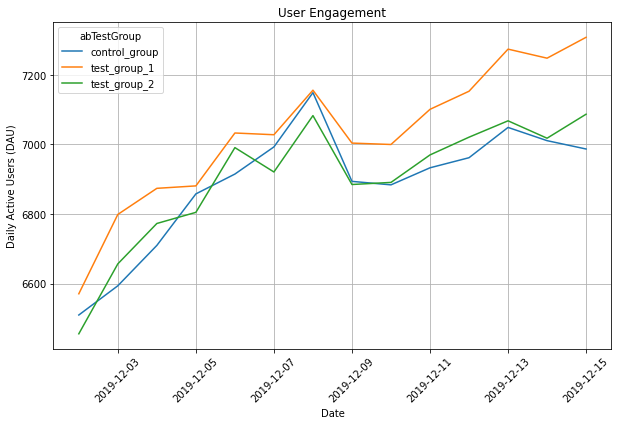

In [27]:
# Plotting DAU 
plt.figure(figsize=(10, 6))
sns.lineplot(
    x='dateActivity', 
    y='DAU', 
    hue='abTestGroup', 
    data=dau
)
plt.grid(True)
plt.xticks(rotation=45)
plt.title('User Engagement')
plt.xlabel('Date')
plt.ylabel('Daily Active Users (DAU)')
plt.show()

The control group displays steady growth, suggesting stable user engagement without any intervention. Test Group 1 sees significant growth, especially towards the end of the period, indicating the reduced price may have positively influenced user activity. Test Group 2 initially matches the control group but then diverges, showing a different pattern of engagement which could be due to the double rewards offered. These trends indicate that pricing and reward strategies can impact user engagement, with Test Group 1's reduced price strategy seemingly the most effective in this interval.

<style>
.anchor-tag {
    display: block;
    position: relative;
    top: -100px;
    visibility: hidden;
}
</style>

<a id="purchasing-behavior" class="anchor-tag"></a>
<h2>Purchasing Behavior</h2>

Since the goal of the analysis is to understand the performance of the Golden Goal IAP across different strategies, we will focus primarily on this product.

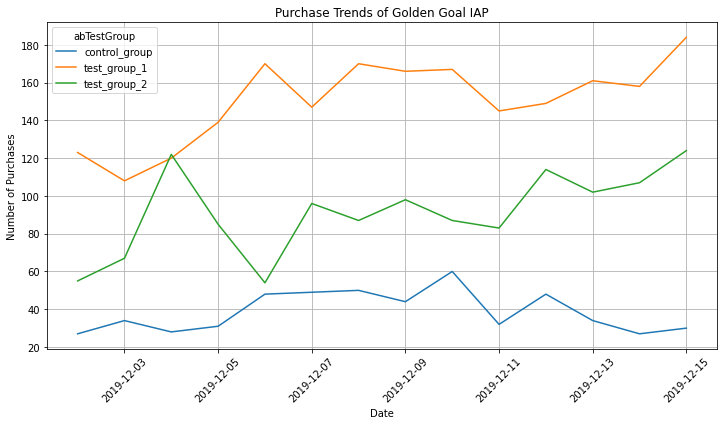

In [28]:
# Calculating the daily number of purchases of the Golden Goal product by the testing group
daily_purchases = df.groupby(['dateActivity', 'abTestGroup'])['goldengoal_purchases'].sum().reset_index(name='Number of Purchases')

# Visualizing Daily Number of Purchases
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_purchases, x='dateActivity', y='Number of Purchases', hue='abTestGroup')
plt.grid(True)
plt.xticks(rotation=45)
plt.title('Purchase Trends of Golden Goal IAP')
plt.xlabel('Date')
plt.ylabel('Number of Purchases')
plt.show()

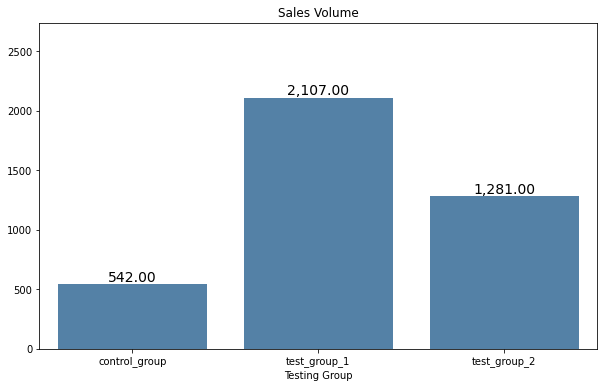

In [29]:
# Calculating Total Purchases by the testing group
total_purchases = df.groupby('abTestGroup')['goldengoal_purchases'].sum().reset_index(name='Total Purchases')

# Visualizing Sales Volume
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(data=total_purchases, x='abTestGroup', y='Total Purchases', color='steelblue')
plt.title('Sales Volume')
plt.xlabel('Testing Group')
plt.ylabel('')
max_value = total_purchases['Total Purchases'].max()
plt.ylim(0, max_value * 1.3)

# Adding the text on top of each bar
for index, value in enumerate(total_purchases['Total Purchases']):
    bar_plot.text(index, value, f'{value:,.2f}', color='black', ha="center", va="bottom", fontsize=14)

plt.show()

Control Group is consistently the lowest in terms of daily purchases, indicating that the standard offering does not generate as many purchases as the test conditions. Test Group 1 (Reduced Price) shows a significant increase in the number of daily purchases compared to the control group. This suggests that the reduced price strategy effectively encourages more users to make purchases. Test Group 2 (Double Rewards) group surpasses the control group in daily purchases. However, the double rewards strategy does not perform better than the reduced price strategy"

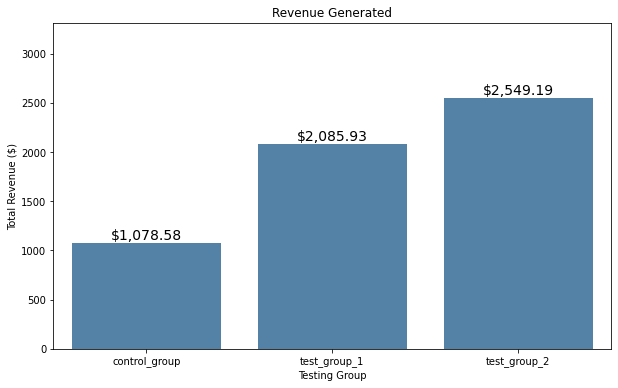

In [30]:
# Calculating Total Revenue by the testing group
total_revenue = df.groupby('abTestGroup')['goldengoal_revenue'].sum().reset_index(name='Total Revenue')

# Visualizing Revenue Generated
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(data=total_revenue, x='abTestGroup', y='Total Revenue', color='steelblue')
plt.title('Revenue Generated')
plt.xlabel('Testing Group')
plt.ylabel('Total Revenue ($)')
max_value = total_revenue['Total Revenue'].max()
plt.ylim(0, max_value * 1.3)

# Adding the text on top of each bar
for index, value in enumerate(total_revenue['Total Revenue']):
    bar_plot.text(index, value, f'${value:,.2f}', color='black', ha="center", va="bottom", fontsize=14)

plt.show()

Control Group generated the least revenue, which aligns with the lower number of daily purchases. Test Group 1 (Reduced Price) shows that despite the increased number of purchases, the total revenue is less than Test Group 2, likely due to the reduced price per purchase. Test Group 2 (Double Rewards) generated the highest revenue and this suggests that the double rewards strategy, despite not reducing the price, is more effective at increasing overall revenue. This could be due to a higher perceived value or greater appeal of the reward, encouraging more users to purchase at the standard price.

In [31]:
# Calculating daily revenue
daily_revenue = df.groupby(['dateActivity', 'abTestGroup'])['goldengoal_revenue'].sum()

# Merging daily revenue with DAU data
arpdau_df = pd.merge(daily_revenue, dau, on=['dateActivity', 'abTestGroup'])

# Calculating ARPDAU (Average Revenue per Daily Active User)
arpdau_df['ARPDAU'] = arpdau_df['goldengoal_revenue'] / arpdau_df['DAU']

# Displaying the ARPDAU data
arpdau_df.head()


,dateActivity,abTestGroup,goldengoal_revenue,DAU,ARPDAU
0,2019-12-02,control_group,53.73,6510,0.008253
1,2019-12-02,test_group_1,121.77,6571,0.018531
2,2019-12-02,test_group_2,109.45,6456,0.016953
3,2019-12-03,control_group,67.66,6594,0.010261
4,2019-12-03,test_group_1,106.92,6799,0.015726


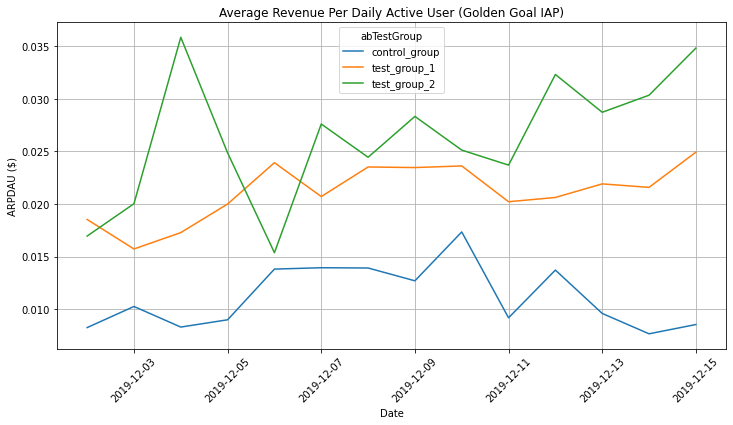

In [32]:
# Plotting ARPDAU by Test Group
plt.figure(figsize=(12, 6))
sns.lineplot(data=arpdau_df, x='dateActivity', y='ARPDAU', hue='abTestGroup')
plt.grid(True)
plt.xticks(rotation=45)
plt.title('Average Revenue Per Daily Active User (Golden Goal IAP)')
plt.xlabel('Date')
plt.ylabel('ARPDAU ($)')
plt.show()

The ARPDAU for the control group, which did not receive any price or reward changes, remains the lowest across the observed period. It shows some fluctuations but maintains a relatively consistent trend, staying below the $0.02 mark. The reduced price strategy for the "Golden Goal" product, shows a higher ARPDAU than the control group, indicating that the reduced price may have encouraged more purchases or higher spending per active user. The ARPDAU for this group fluctuates and generally trends upward towards the end of the period, indicating that the strategy may have gained traction as time went on. Exhibiting the highest ARPDAU of all three groups, test group 2's double rewards strategy seems to be the most effective in terms of revenue per user. The ARPDAU for this group shows significant variability, with notable peaks, suggesting that on certain days, the strategy was particularly effective.

<style>
.anchor-tag {
    display: block;
    position: relative;
    top: -100px;
    visibility: hidden;
}
</style>

<a id="statistical-analysis" class="anchor-tag"></a>
<h1>Statistical Analysis</h1>

We will conduct the statistical analysis based on the ARPDAU metric since it is a comprehensive metric that combines aspects of revenue and user engagement. Given that there are three groups testing groups, the statistical method used should be Analysis of Variance (ANOVA) because it is capable of comparing means across more than two independent groups. In this context, a one-way ANOVA test should be used to determine whether there are any statistically significant differences between the means of the three testing groups.

We will test the following hypothesis:

H0: The means of ARPDAU are the same across all groups

H1: At least one group's mean of ARPDAU is different from the others

In [33]:
# First, we need to check if the assumptions for ANOVA are met
# Checking normality for ARPDAU in each group
normality_test_results = {}
for group in arpdau_df['abTestGroup'].unique():
    group_data = arpdau_df[arpdau_df['abTestGroup'] == group]['ARPDAU']
    stat, p = stats.shapiro(group_data)
    normality_test_results[group] = p

# Checking homogeneity of variances
levene_result = levene(
    arpdau_df[arpdau_df['abTestGroup'] == 'control_group']['ARPDAU'],
    arpdau_df[arpdau_df['abTestGroup'] == 'test_group_1']['ARPDAU'],
    arpdau_df[arpdau_df['abTestGroup'] == 'test_group_2']['ARPDAU']
)

normality_test_results, levene_result

({'control_group': 0.0612400621175766,
  'test_group_1': 0.5727487206459045,
  'test_group_2': 0.8645438551902771},
 LeveneResult(statistic=4.768518958382151, pvalue=0.014038835706510093))

Before conducting the ANOVA test we need to check if the normality and homogeneity assumptions for ANOVA are met. 

Normality assumption: Since the p-values are greater than 0.05, we fail to reject the null hypothesis of normality for all groups. This suggests that the ARPDAU data for each group follows a normal distribution. 

Homogeneity assumption: Although the p-value is less than 0.05, indicating that the variances of the groups are not equal (violating the homogeneity assumption), ANOVA is robust to this violation, especially with equal or similar sample sizes. Thus, we can proceed with the ANOVA one-way test.

If we have enough evidence to reject the null hypothesis that there is no difference in ARPDAU across the groups based on ANOVA results, we will need to perform post-hoc tests to identify which specific group pairs have significant differences in ARPDAU. Thus, Tukey's HSD analysis will provide a clearer understanding of how each test group's ARPDAU compares to the others.

In [34]:
# Conducting one-way ANOVA test
anova_result = stats.f_oneway(
    arpdau_df[arpdau_df['abTestGroup'] == 'control_group']['ARPDAU'],
    arpdau_df[arpdau_df['abTestGroup'] == 'test_group_1']['ARPDAU'],
    arpdau_df[arpdau_df['abTestGroup'] == 'test_group_2']['ARPDAU']
)

# If ANOVA test shows significant differences, proceed with Tukey's HSD post-hoc test
if anova_result.pvalue < 0.05:
    tukey_result = pairwise_tukeyhsd(endog=arpdau_df['ARPDAU'], groups=arpdau_df['abTestGroup'], alpha=0.05)
else:
    tukey_result = "ANOVA test did not show significant differences, so post-hoc test is not required."

anova_result, tukey_result

(F_onewayResult(statistic=46.40616243347265, pvalue=4.859789360684345e-11),
 <statsmodels.sandbox.stats.multicomp.TukeyHSDResults at 0x200b48370a0>)

The p-value is significantly less than 0.05, indicating strong evidence against the null hypothesis (there are significant differences in ARPDAU among the three groups). Thus, we proceeded with Tukey's HSD post-hoc test to determine which specific groups differ from each other.

In [35]:
# Displaying the results of Tukey's HSD post-hoc test
tukey_result.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
control_group,test_group_1,0.01,0.0,0.0061,0.0139,True
control_group,test_group_2,0.0152,0.0,0.0113,0.0191,True
test_group_1,test_group_2,0.0052,0.0069,0.0013,0.0091,True


Control Group vs Test Group 1: There is a statistically significant difference in ARPDAU between the control group and test group 1. The ARPDAU for test group 1 is higher than that of the control group.

Control Group vs Test Group 2: There is a statistically significant difference in ARPDAU between the control group and test group 2. The ARPDAU for test group 2 is higher than that of the control group.

Test Group 1 vs Test Group 2: There is a statistically significant difference in ARPDAU between test group 1 and test group 2. The ARPDAU for test group 2 is higher than that of test group 1.

In brief, all three test groups significantly differ from each other in terms of ARPDAU. Specifically, test group 2 shows the highest ARPDAU, followed by test group 1, and then the control group. This suggests that the strategies implemented in test groups 1 and 2 are more effective in increasing ARPDAU compared to the control group, with test group 2 being the most effective.

<style>
.anchor-tag {
    display: block;
    position: relative;
    top: -100px;
    visibility: hidden;
}
</style>

<a id="summary-of-results" class="anchor-tag"></a>
<h1>Summary of the Results</h1>

After conducting a throughout analysis of the A/B testing data of the Golden Goal IAP, it is recommended to choose the regular price and double rewards strategy to improve the monetisation. The effects of the double rewards strategy are demonstrated in the user engagement trends across the 14-day duration, the revenue generated during the duration of the experiment, and the Average Revenue generated Per Daily Active User (ARPDAU metric). This recommendation is also supported by the results of the statistical analysis conducted on the key metric ARPDAU that combines aspects of both user engagement and monetisation. The results indicated statistical significance between testing groups when compared to each other, concluding that the double rewards strategy outperformed the reduced price group and the initial (regular price and regular rewards) group.